# MNIST on the Healpix sphere

In this notebook we show how to use NNhealpix to reproduce a classic NN test on the Healpix sphere: the recognition of handwritten digits from the MNIST dataset.

In [1]:
# import tensorflow.keras
from tensorflow.keras.datasets import mnist
# import tensorflow.keras.layers
from nnhealpix.projections import img2healpix, img2healpix_planar
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from tensorflow.keras.utils import to_categorical
import nnhealpix.layers
from tensorflow.keras import backend as K
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# K.common.set_image_dim_ordering('th')
tf.random.set_seed(7) # in order to reproduce the same results

### Download the MNIST data and take a subset of it

In [19]:
Ntrain = 10000
Ntest = 100
(X_train_temp, y_train), (X_test_temp, y_test) = mnist.load_data()
X_train_temp = X_train_temp[0:Ntrain]
y_train = y_train[0:Ntrain]
X_test_temp = X_test_temp[0:Ntest]
y_test = y_test[0:Ntest]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)

(10000, 10)


### Project the dataset on healpix map

The projection is done at on the same portion of the Healpix map for all the cases.

In [20]:
nside = 16
X_train_hp = img2healpix_planar(X_train_temp, nside, 90, 0, 100, 100)
X_test_hp = img2healpix_planar(X_test_temp, nside, 90, 0, 100, 100)

Here we plot an image as an example: first as a 2D flat image, then as a Healpix full-sky map with the digit projected along the Equator.

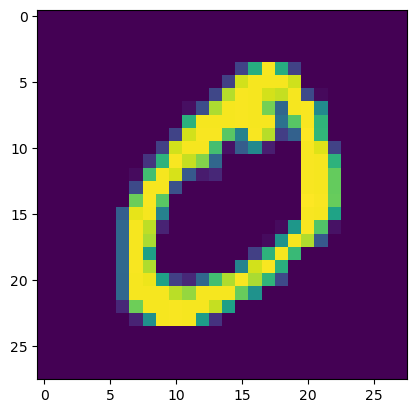

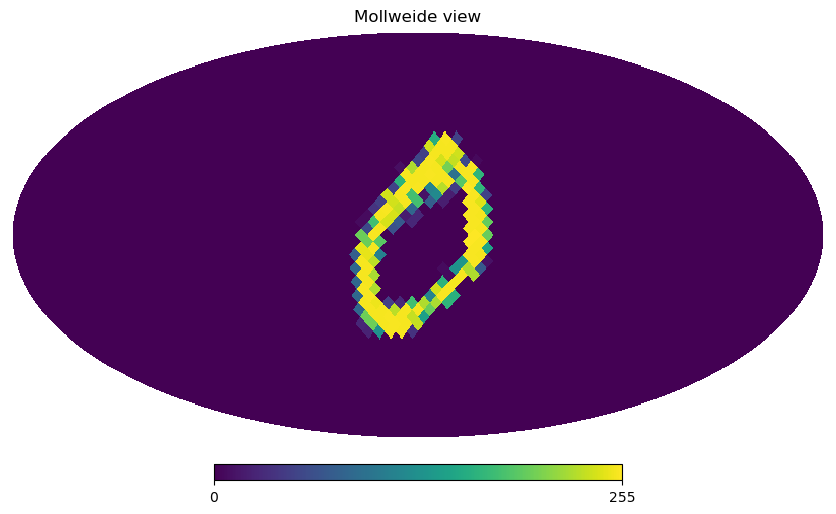

In [21]:
plt.imshow(X_train_temp[1])
hp.mollview(X_train_hp[1])

### Build the train, test, and validation sets

In [22]:
seed = 7
np.random.seed(seed)

In [23]:
X_train = X_train_hp.reshape(X_train_hp.shape[0], len(X_train_hp[0]), 1).astype('float32')
X_test = X_test_hp.reshape(X_test_hp.shape[0], len(X_train_hp[0]), 1).astype('float32')

In [24]:
X_train = X_train / 255
X_test = X_test / 255
num_classes = y_train.shape[1]
shape = (len(X_train_hp[0]), 1)
print(X_train.shape, shape, y_train.shape)

(10000, 3072, 1) (3072, 1) (10000, 10)


### Build a NN architecture

In [25]:
inputs = tf.keras.layers.Input(shape)
x = nnhealpix.layers.ConvNeighbours(nside, filters=32, kernel_size=9)(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = nnhealpix.layers.MaxPooling(nside, 8)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(num_classes)(x)
out = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 3072, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ order_map_4 (OrderMap)          │ (None, 27648, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3072, 32)       │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 3072, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ order_map_5 (OrderMap)          │ (None, 3072, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 768, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 768, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,145,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,147,434 (12.01 MB)

 Trainable params: 3,147,434 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

### …and train the network

In [27]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=24, batch_size=128, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/24
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9949 - loss: 9.2792e-04 - val_accuracy: 0.9800 - val_loss: 0.0037
Epoch 2/24
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9935 - loss: 0.0011 - val_accuracy: 0.9800 - val_loss: 0.0039
Epoch 3/24
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9927 - loss: 0.0013 - val_accuracy: 0.9800 - val_loss: 0.0038
Epoch 4/24
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9949 - loss: 9.3416e-04 - val_accuracy: 0.9500 - val_loss: 0.0055
Epoch 5/24
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9956 - loss: 8.8532e-04 - val_accuracy: 0.9600 - val_loss: 0.0059
Epoch 6/24
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9932 - loss: 0.0011 - val_accuracy: 0.9800 - val_loss: 0.0028
Epoch 7/24
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9967 - loss: 7.3339e-04 - val_accuracy: 0.9700 - val_loss: 0.0046
Epoch 8/24
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9961 - loss: 7.4317e-04 - val_

### Application of the same NN architecture to planar images

We apply standard NN to the same dataset to compare the performance. Example adapted from https://keras.io/examples/mnist_cnn/

In [11]:
batch_size = 128
num_classes = 10
epochs = 12

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [13]:
seed = 7
np.random.seed(seed)

In [14]:
y_test.shape

(10000,)

In [15]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [16]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
scores = model.evaluate(x_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))


Epoch 1/12


/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.8424 - loss: 0.4912 - val_accuracy: 0.9833 - val_loss: 0.0521
Epoch 2/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9707 - loss: 0.0967 - val_accuracy: 0.9881 - val_loss: 0.0358
Epoch 3/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9784 - loss: 0.0721 - val_accuracy: 0.9880 - val_loss: 0.0339
Epoch 4/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9826 - loss: 0.0566 - val_accuracy: 0.9896 - val_loss: 0.0313
Epoch 5/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9848 - loss: 0.0466 - val_accuracy: 0.9882 - val_loss: 0.0373
Epoch 6/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9878 - loss: 0.0416 - val_accuracy: 0.9903 - val_loss: 0.0311
Epoch 7/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9879 - loss: 0.0381 - val_accuracy: 0.9906 - val_loss: 0.0299
Epoch 8/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9903 - loss: 0.0325 - val_accurac

# Performances are comparable!



